Create a sentiment analyzer from scratch.

Our roadmap: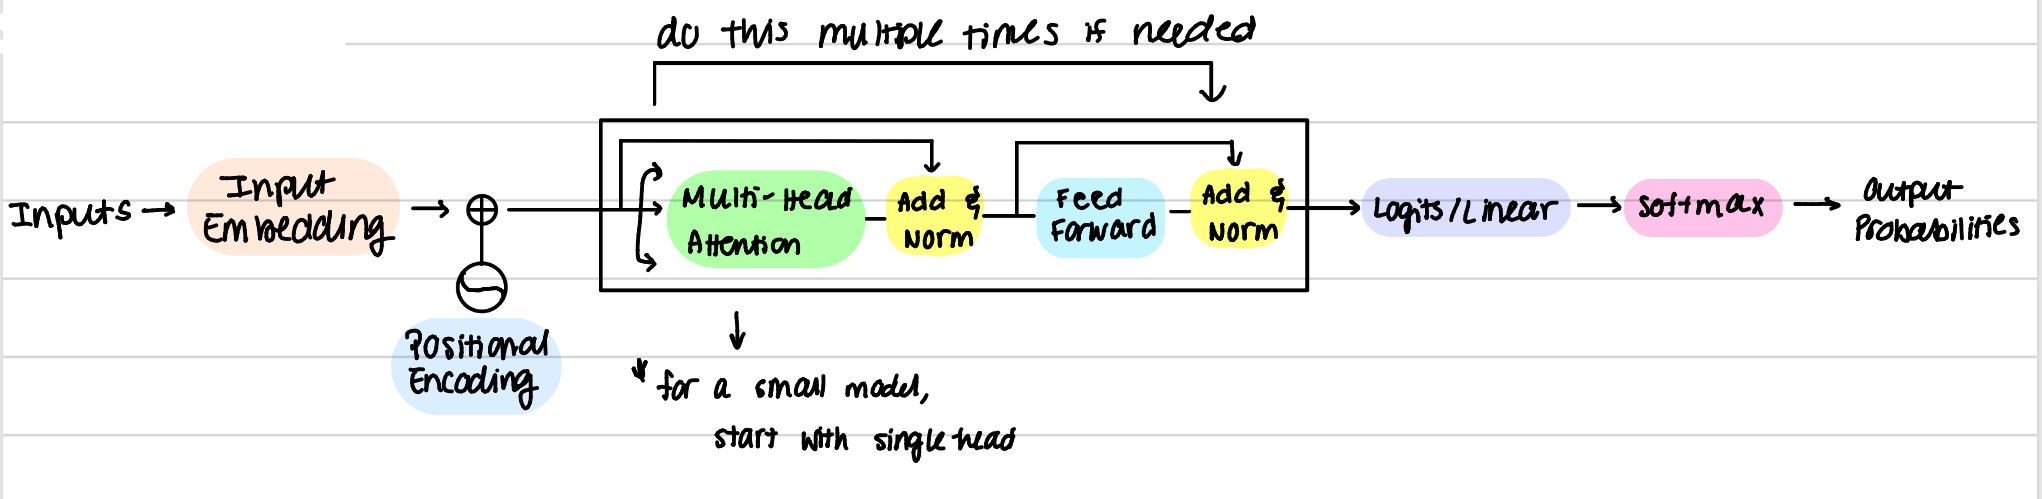

# **1. Dataset Preprocessing**

## **1A. Load Dataset**

In [75]:
!pip install kagglehub[pandas-datasets]

In [76]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]

import kagglehub
from kagglehub import KaggleDatasetAdapter

# Load the latest version using ISO-8859-1 encoding
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "nursyahrina/chat-sentiment-dataset",
    "chat_dataset.csv",
    pandas_kwargs={"encoding": "ISO-8859-1"}
)

print("df shape:", df.shape)

/tmp/ipython-input-2189190178.py:8: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


df shape: (584, 2)


In [77]:
df.head()

,message,sentiment
0,I really enjoyed the movie,positive
1,The food was terrible,negative
2,I'm not sure how I feel about this,neutral
3,The service was excellent,positive
4,I had a bad experience,negative


## **1B. Train-Test Split**

In [78]:
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

split_idx = int(0.8 * len(df_shuffled)) # 80% train 20% test
train = df_shuffled[:split_idx]
test = df_shuffled[split_idx:]

print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (467, 2)
Test shape: (117, 2)


## **1C. Identify Balance**

In [79]:
import matplotlib.pyplot as plt

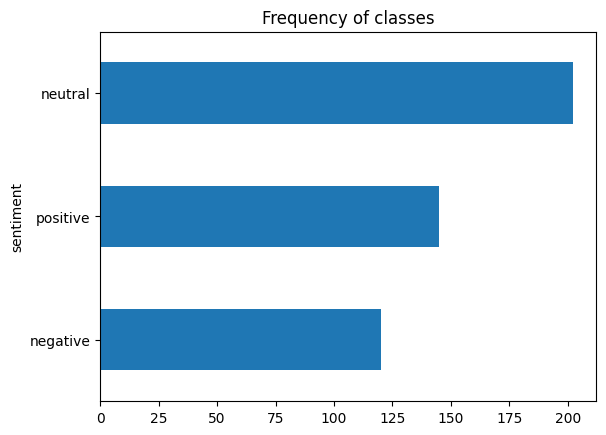

In [80]:
train['sentiment'].value_counts(ascending=True).plot.barh()
plt.title("Frequency of classes")
plt.show()

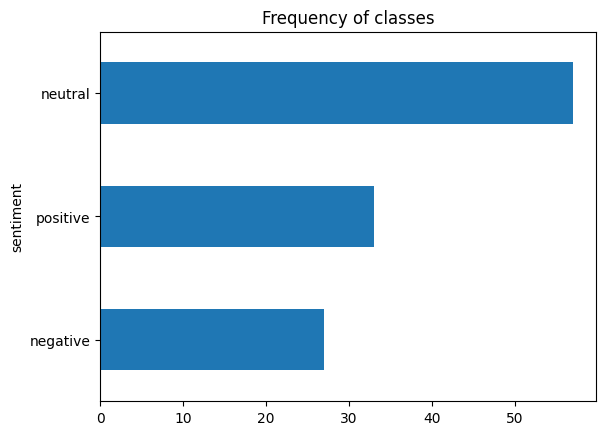

In [81]:
test['sentiment'].value_counts(ascending=True).plot.barh()
plt.title("Frequency of classes")
plt.show()

In [82]:
import pandas as pd

In [83]:
# drop 50 rows with "neutral"

train_np = train[(train['sentiment'] == 'negative') | (train['sentiment'] == 'positive')]
train_ne = train[train['sentiment'] == 'neutral']
train_ne = train_ne.iloc[:-50]
train = pd.concat([train_np, train_ne], ignore_index=True, axis=0)

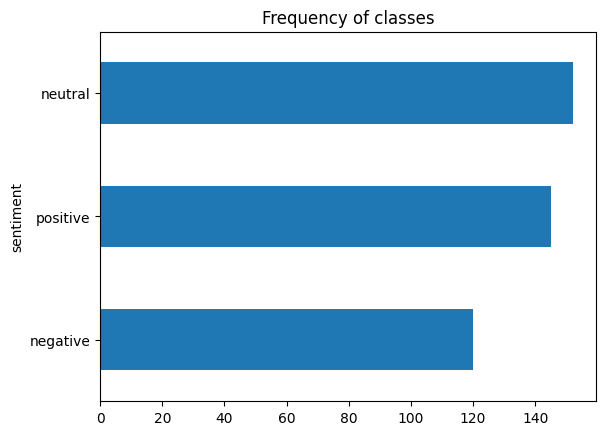

In [84]:
# test again

train['sentiment'].value_counts(ascending=True).plot.barh()
plt.title("Frequency of classes")
plt.show()

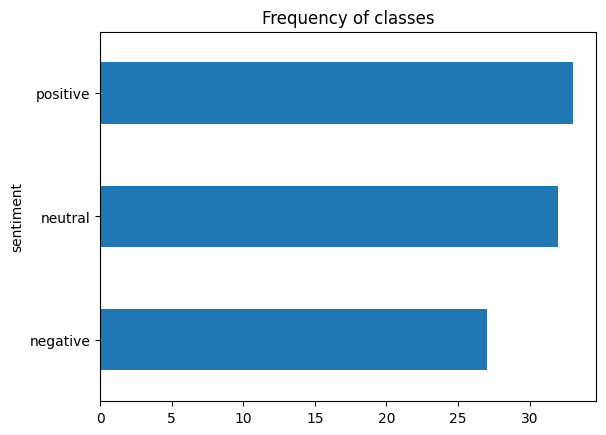

In [85]:
# same with test but drop 25

test_np = test[(test['sentiment'] == 'negative') | (test['sentiment'] == 'positive')]
test_ne = test[test['sentiment'] == 'neutral']
test_ne = test_ne.iloc[:-25]
test = pd.concat([test_np, test_ne], ignore_index=True, axis=0)

test['sentiment'].value_counts(ascending=True).plot.barh()
plt.title("Frequency of classes")
plt.show()

## **1D. Look at words per tweet**

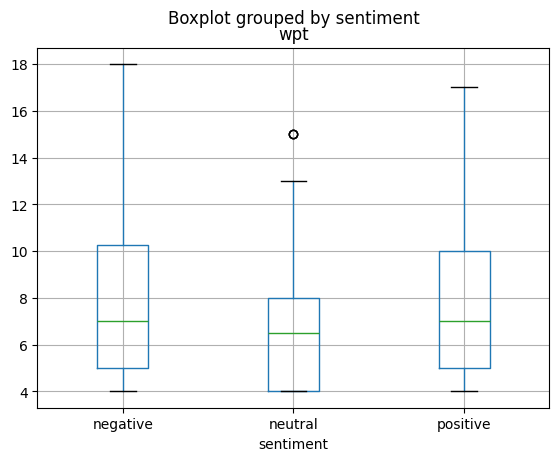

In [86]:
train.dropna(inplace=True)
train['wpt'] = train['message'].str.split().apply(len)
train.boxplot("wpt", by="sentiment")
plt.show()

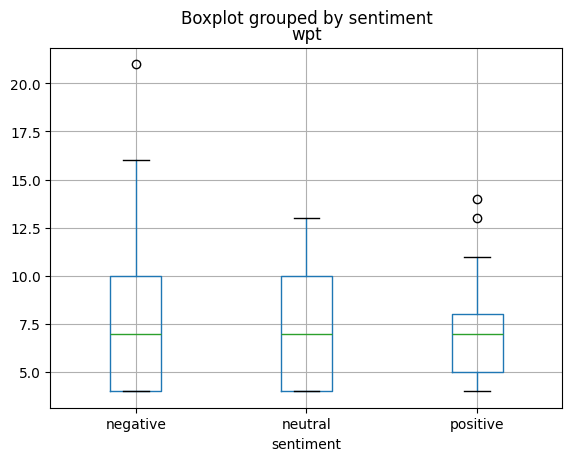

In [87]:
test.dropna(inplace=True)
test['wpt'] = test['message'].str.split().apply(len)
test.boxplot("wpt", by="sentiment")
plt.show()

Conclusion: no need to truncate since the maximum number of words per tweet is ~16-18, which is relatively low.

## **1E. Tokenizing and Lemmatizing**

For the sake of efficiency, we will use NLTK's `WordNetLemmatizer`.

In [88]:
from nltk import WordNetLemmatizer
import re

In [89]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [90]:
lemmatizer = WordNetLemmatizer()

In [91]:
word2idx = {'<PAD>': 0, '<UNK>': 1}

In [92]:
idx = 2

In [93]:
def tokenize(text):
  text = re.sub(r"[^a-z0-9\\s]", " ", text)
  text = re.sub(r"\s+", " ", text)

  tokens = text.split()
  tokens = [lemmatizer.lemmatize(token) for token in tokens]
  return tokens

In [94]:
all_tokens = []
for i, row in train.iterrows():
  text = str(row['message']).lower()
  tokens = tokenize(text)

  all_tokens.extend(tokens)

In [96]:
len(word2idx)

587

# **2. Create Embeddings**

## **2A. Embedding Matrix**

In [97]:
dim = 128 #dimension of embeddings
vocab_size = len(word2idx)

In [98]:
import numpy as np

In [99]:
embedding_matrix = np.random.normal(0, 0.01, size=(vocab_size, dim))

In [100]:
def generate_embeddings(text):
  tokens = tokenize(text)
  indices = [word2idx.get(token, word2idx["<UNK>"]) for token in tokens]
  embeddings = []

  for index in indices:
    embeddings.append(embedding_matrix[index])

  return np.array(embeddings)

In [101]:
# e.g. convert a sentence to an embedding

sample_sentence = str(train.iloc[np.random.randint(0, train.shape[0])]['message'])
embedding = generate_embeddings(sample_sentence)
print(embedding)

[[-3.77574957e-03  8.03118880e-04 -9.72982160e-03  2.49701166e-03
  -5.64229966e-04 -1.28448804e-02  4.94791036e-03 -6.97023875e-04
   9.35741885e-03 -5.61016836e-03 -7.82021860e-03 -1.67143964e-03
   3.48410709e-03  1.42330029e-02 -1.32556239e-02 -5.91984538e-03
  -7.08029541e-03  1.13244958e-02  4.55223311e-03  4.51056734e-03
   1.57550800e-02  6.59459793e-04 -4.57435891e-03 -3.23123345e-03
  -6.62660485e-03  6.04921220e-03 -1.43133507e-02 -7.30459086e-03
  -3.21299565e-03 -4.70057599e-03 -1.28359073e-02 -5.19367582e-04
  -9.33831700e-03  4.63551405e-03  1.67356694e-03 -9.77109873e-03
   4.27350848e-03 -1.05265010e-02  1.23466376e-02 -2.36575991e-03
   1.12208963e-02 -2.35759647e-03 -1.58945655e-02 -2.38517502e-02
  -8.34983744e-03  1.60897404e-02 -7.40747698e-03 -1.23329778e-02
   7.85602683e-03  2.32194313e-02  6.47700201e-03  2.37873546e-03
   5.24089691e-03  1.16083176e-03  6.82969629e-03 -3.59543113e-04
   3.69960579e-03 -2.14350001e-02 -1.39685015e-02 -6.65816362e-03
  -6.45098

## **2B. Analyze `<UNK>` Token Frequency**

See how frequent `<UNK>` tokens are to see if we must extend the vocab or drop some rows.

In [102]:
def count_unk_tokens(text):
    tokens = tokenize(text)
    indices = [word2idx.get(token, word2idx["<UNK>"]) for token in tokens]
    return indices.count(word2idx["<UNK>"])

In [103]:
train['unk_count'] = train['message'].apply(count_unk_tokens)

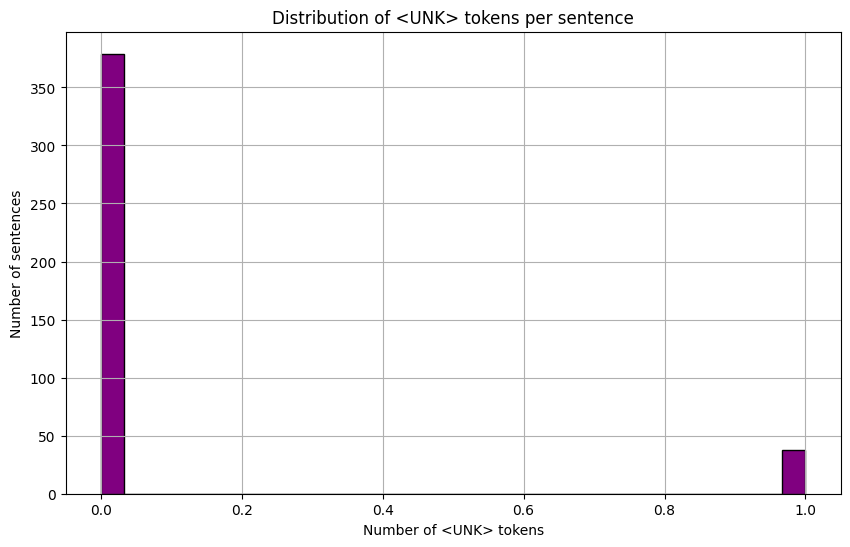

In [104]:
plt.figure(figsize=(10, 6))
plt.hist(train['unk_count'], bins=30, color='purple', edgecolor='black')
plt.title("Distribution of <UNK> tokens per sentence")
plt.xlabel("Number of <UNK> tokens")
plt.ylabel("Number of sentences")
plt.grid(True)
plt.show()

Conclusion: Nothing to drop.

## **2C. Analayze Non-tokenizable Texts**

In [105]:
def is_valid(text):
    tokens = tokenize(text)
    return len(tokens) > 0 and sum(1 for t in tokens if t not in word2idx) < len(tokens)

invalid = []
for idx, row in train.iterrows():
  text = row['message']
  if not is_valid(text):
    invalid.append(idx)

print(len(invalid))

0


All rows are tokenizable.

# **3. Positional Encoding**

$$
\text{PE}_{(\text{pos},\, 2i)} = \sin\left(\frac{\text{pos}}{10000^{\frac{2i}{d}}}\right)
$$
$$
\text{PE}_{(\text{pos},\, 2i+1)} = \cos\left(\frac{\text{pos}}{10000^{\frac{2i}{d}}}\right)
$$

In [106]:
def positional_encode(embeddings, dim=dim): #input an embedded sentence
  for pos, embedding in enumerate(embeddings):
    for i, _ in enumerate(embedding):
      exp = (2 * i) / dim
      den = 10000 ** exp
      val = pos / den
      if i % 2 == 0:
        embedding[i] += np.sin(val)
      else:
        embedding[i] += np.cos(val)
    embeddings[pos] = embedding

  return embeddings

# **4. Transformer Architecture**

## **4A. Multi-head Attention**

$$
\text{Attention}(Q, K, V) = \text{softmax}\left( \frac{QK^\top}{\sqrt{d_k}} \right) V
$$

In [107]:
def softmax(x):
    x = x - np.max(x, axis=-1, keepdims=True)
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

In [108]:
def multi_head_attention(X, W_q_heads, W_k_heads, W_v_heads, W_o): #input an embedded sentence
  outputs = []
  A_list = []
  Q_list = []
  K_list = []
  V_list = []

  for idx, (W_q, W_k, W_v), in enumerate(zip(W_q_heads, W_k_heads, W_v_heads)):
    Q = X @ W_q
    K = X @ W_k
    V = X @ W_v

    scores = Q @ K.T
    head_dim = Q.shape[-1]
    scores_scaled = scores / np.sqrt(head_dim)
    A = softmax(scores_scaled)

    output = A @ V

    outputs.append(output)
    A_list.append(A)
    Q_list.append(Q)
    K_list.append(K)
    V_list.append(V)

  concat = np.concatenate(outputs, axis=-1)

  out = concat @ W_o

  return out, A_list, Q_list, K_list, V_list

## **4B. Add + Layernorm**

In [109]:
def add_substep(X, substep):
  return X + substep

$$
\text{LayerNorm}(x) = \gamma \cdot \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta
$$

In [110]:
def LayerNorm(X, gamma, beta, eps=1e-5):
  mean = X.mean(axis=1, keepdims=True)
  var = X.var(axis=1, keepdims=True)
  norm = (X - mean) / np.sqrt(var + eps)
  output = gamma * norm + beta

  return output

## **4C. Feed-Forward Network**

$$
\text{FFN}(x) = \text{ReLU}(xW_1 + b_1) W_2 + b_2
$$

In [111]:
def relu(x):
  return np.maximum(0, x)

In [112]:
def ffn(X, W_1, W_2, b_1, b_2):
  h1 = X @ W_1 + b_1
  a1 = relu(h1)

  output = a1 @ W_2 + b_2

  return output, a1, h1

## **4D. Transformer Block Class**

In [113]:
class TransformerBlock:
  def __init__(self, id, dim, num_heads):
    self.cached = {}
    self.id = id
    self.dim = dim
    self.num_heads = num_heads
    self.init_weights()

  def init_weights(self):
    self.head_dim = dim // num_heads
    d_ff = dim * 4

    self.cached = {
        "W_q_heads": [np.random.normal(0, 0.5, size=(dim, head_dim)) for _ in range(num_heads)],
        "W_k_heads": [np.random.normal(0, 0.5, size=(dim, head_dim)) for _ in range(num_heads)],
        "W_v_heads": [np.random.normal(0, 0.5, size=(dim, head_dim)) for _ in range(num_heads)],
        "W_o": np.random.normal(0, 0.5, size=(dim, dim)),

        "gamma1": np.ones(dim),
        "beta1": np.zeros(dim),

        "W_1": np.random.normal(0, np.sqrt(2 / (dim + d_ff)), size=(dim, d_ff)),
        "b_1": np.zeros(d_ff),
        "W_2": np.random.normal(0, np.sqrt(2 / (dim + d_ff)), size=(d_ff, dim)),
        "b_2": np.zeros(dim),

        "gamma2": np.ones(dim),
        "beta2": np.zeros(dim),
    }

  def forward(self, X):
    cached = self.cached

    cached['x'] = np.array(X)

    attn, A_list, Q_list, K_list, V_list = multi_head_attention(X, W_q_heads=cached['W_q_heads'],
                                          W_k_heads=cached['W_k_heads'], W_v_heads=cached['W_v_heads'],
                                          W_o=cached['W_o'])

    cached['attn'] = attn
    cached['A_list'] = A_list
    cached['Q_list'] = Q_list
    cached['K_list'] = K_list
    cached['V_list'] = V_list

    attn_norm = LayerNorm(attn, gamma=np.ones_like(attn[0]), beta=np.zeros_like(attn[0]))
    cached['attn_norm'] = attn_norm
    res1 = add_substep(X, attn_norm)
    cached['res1'] = res1

    ln1 = LayerNorm(res1, gamma=cached['gamma1'], beta=cached['beta1'])
    cached['ln1'] = ln1

    ffn_out, a1, h1 = ffn(ln1, W_1=cached['W_1'], W_2=cached['W_2'], b_1=cached['b_1'], b_2=cached['b_2'])
    cached['ffn_out'] = ffn_out
    cached['a1'] = a1
    cached['h1'] = h1

    res2 = add_substep(ln1, ffn_out)
    cached['res2'] = res2

    gamma2 = cached['gamma2']
    beta2 = cached['beta2']
    ln2 = LayerNorm(res2, gamma=cached['gamma2'], beta=cached['beta2'])
    cached['ln2'] = ln2

    return ln2

  def backward(self, grad_out, learning_rate):
    cached = self.cached
    dim = grad_out.shape[1]
    head_dim = self.head_dim

    grad_res2, grad_gamma2, grad_beta2 = layernorm_backward(grad_out, cached['res2'], cached['gamma2'], cached['beta2'])
    cached['gamma2'] -= learning_rate * grad_gamma2
    cached['beta2'] -= learning_rate * grad_beta2

    grad_ffn_out = grad_res2.copy()
    a1 = cached['a1']
    h1 = cached['h1']

    W_2 = cached['W_2']
    grad_W_2 = a1.T @ grad_ffn_out
    grad_b_2 = grad_ffn_out.sum(axis=0)
    grad_a1 = grad_ffn_out @ W_2.T
    grad_h1 = grad_a1 * (h1 > 0)

    ln1 = cached['ln1']
    W_1 = cached['W_1']
    grad_W_1 = ln1.T @ grad_h1
    grad_b_1 = grad_h1.sum(axis=0)
    grad_ln1 = grad_h1 @ W_1.T

    cached['W_2'] -= learning_rate * grad_W_2
    cached['b_2'] -= learning_rate * grad_b_2
    cached['W_1'] -= learning_rate * grad_W_1
    cached['b_1'] -= learning_rate * grad_b_1

    grad_res1, grad_gamma1, grad_beta1 = layernorm_backward(grad_ln1, cached['res1'], cached['gamma1'], cached['beta1'])
    cached['gamma1'] -= learning_rate * grad_gamma1
    cached['beta1'] -= learning_rate * grad_beta1

    grad_context = grad_res1.copy()
    grad_heads = np.split(grad_context, num_heads, axis=1)


    grad_Q_total = np.zeros_like(cached['x'])
    grad_K_total = np.zeros_like(cached['x'])
    grad_V_total = np.zeros_like(cached['x'])

    grad_W_q_list = []
    grad_W_k_list = []
    grad_W_v_list = []

    for i in range(num_heads):
      A = cached['A_list'][i]
      Q = cached['Q_list'][i]
      K = cached['K_list'][i]
      V = cached['V_list'][i]
      W_q = cached['W_q_heads'][i]
      W_k = cached['W_k_heads'][i]
      W_v = cached['W_v_heads'][i]

      grad_out_i = grad_heads[i]

      grad_V = A.T @ grad_out_i
      # print(f"grad_V norm (head {i}):", np.linalg.norm(grad_V))
      grad_A = grad_out_i @ V.T
      grad_scores = softmax_backward(grad_A, A)

      scale = np.sqrt(head_dim)
      grad_Q = grad_scores @ K / scale
      grad_K = grad_scores.T @ Q / scale

      grad_W_q = cached['x'].T @ grad_Q
      grad_W_k = cached['x'].T @ grad_K
      grad_W_v = cached['x'].T @ grad_V

      cached['W_q_heads'][i] -= learning_rate * grad_W_q
      cached['W_k_heads'][i] -= learning_rate * grad_W_k
      cached['W_v_heads'][i] -= learning_rate * grad_W_v

      grad_Q_total += grad_Q @ W_q.T
      grad_K_total += grad_K @ W_k.T
      grad_V_total += grad_V @ W_v.T

      grad_W_q_list.append(grad_W_q.copy())
      grad_W_k_list.append(grad_W_k.copy())
      grad_W_v_list.append(grad_W_v.copy())

    grad_input = grad_Q_total + grad_K_total + grad_V_total
    cached['grad_W_q'] = grad_W_q_list
    cached['grad_W_k'] = grad_W_k_list
    cached['grad_W_v'] = grad_W_v_list
    cached['grad_W_1'] = grad_W_1.copy()
    cached['grad_W_2'] = grad_W_2.copy()
    cached['grad_b_1'] = grad_b_1.copy()
    cached['grad_b_2'] = grad_b_2.copy()
    cached['grad_gamma1'] = grad_gamma1.copy()
    cached['grad_beta1'] = grad_beta1.copy()
    cached['grad_gamma2'] = grad_gamma2.copy()
    cached['grad_beta2'] = grad_beta2.copy()

    return grad_input

# **5. Classification Head Class**

In [114]:
class ClassifierHead:
  def __init__(self, dim, num_classes=3):
    self.W_vocab = np.random.normal(0, np.sqrt(2 / dim), size=(dim, num_classes))
    self.b_vocab = np.zeros(num_classes)
    self.cached = {}

  def probabilities(self, X_cls):
    logits = X_cls @ self.W_vocab + self.b_vocab

    return softmax(logits), logits

# **6. Forward Pass**

In [115]:
label2idx = {'negative': 0, 'neutral': 1, 'positive': 2}

In [116]:
def forward(text, transformer_blocks, classifier_head):
  X = generate_embeddings(text)
  X = positional_encode(X)

  for block in transformer_blocks:
    X = block.forward(X)

  x_cls = X[0]
  probs, logits = classifier_head.probabilities(x_cls)

  classifier_head.cached['logits'] = logits
  classifier_head.cached['x_cls'] = x_cls
  classifier_head.cached['probs'] = probs

  print("Logits:", logits.round(2))
  print("Probs:", probs.round(2))

  return probs, logits

# **7. Backward Pass**

In [117]:
def cross_entropy_loss(probs, label, eps=0.1):
  return -np.log(probs[label])

In [118]:
def layernorm_backward(grad_output, X, gamma, beta, eps=1e-4):
    N, D = X.shape

    mean = X.mean(axis=1, keepdims=True)
    var = X.var(axis=1, keepdims=True)
    std = np.sqrt(var + eps)
    norm = (X - mean) / std

    grad_gamma = np.sum(grad_output * norm, axis=0)
    grad_beta = np.sum(grad_output, axis=0)

    dnorm = grad_output * gamma

    dvar = np.sum(dnorm * (X - mean) * -0.5 * std**-3, axis=1, keepdims=True)
    dmean = (np.sum(dnorm * -1 / std, axis=1, keepdims=True) + dvar * np.mean(-2 * (X - mean), axis=1, keepdims=True))

    grad_input = dnorm / std + dvar * 2 * (X - mean) / D + dmean / D

    return grad_input, grad_gamma, grad_beta

In [119]:
def softmax_backward(grad_output, softmax_output):
    return softmax_output * (grad_output - np.sum(grad_output * softmax_output, axis=-1, keepdims=True))

In [120]:
# gradient descent and backpropogation
def backward(text, label, transformer_blocks, classifier_head, embedding_matrix, learning_rate):
  cached = classifier_head.cached
  probs = cached['probs']
  ground_truth = label2idx[label]
  loss = cross_entropy_loss(probs, ground_truth)
  grad_logits = cached['probs'].copy()
  grad_logits[ground_truth] -= 1

  x_cls = cached['x_cls']
  W_vocab = classifier_head.W_vocab
  grad_W_vocab = np.outer(x_cls, grad_logits)
  grad_x_cls = grad_logits @ W_vocab.T
  classifier_head.W_vocab -= learning_rate * grad_W_vocab

  classifier_head.b_vocab -= learning_rate * grad_logits
  classifier_head.cached['grad_b_vocab'] = grad_logits.copy()

  ln2 = transformer_blocks[-1].cached['ln2']
  grad_hidden = np.zeros_like(ln2)
  grad_hidden[0] = grad_x_cls


  for block in reversed(transformer_blocks):
    grad_hidden = block.backward(grad_hidden, learning_rate)


  input_ids = [word2idx.get(tok, word2idx["<UNK>"]) for tok in tokenize(text)]
  for i, idx in enumerate(input_ids):

    embedding_matrix[idx] -= learning_rate * grad_hidden[i]
    norm = np.linalg.norm(grad_hidden[i])
    if norm > 1:
        grad_hidden[i] = grad_hidden[i] / norm
    embedding_matrix[idx] -= learning_rate * grad_hidden[i]
    #print("Embedding update norm:", np.linalg.norm(grad_hidden[i]))
    #print("Before:", embedding_matrix[idx][:5])
    embedding_matrix[idx] -= learning_rate * grad_hidden[i]
    #print("After:", embedding_matrix[idx][:5])

  classifier_head.cached['grad_W_vocab'] = grad_W_vocab.copy()
  classifier_head.cached['grad_logits'] = grad_logits.copy()

  print("Grad norm embedding:", np.linalg.norm(grad_hidden))
  print("Grad norm W_vocab:", np.linalg.norm(classifier_head.cached['grad_W_vocab']))

  return loss

# **8. Training Start**

## **8A. Initialize Classes**

In [121]:
num_heads = 4
head_dim = dim // num_heads

transformer_blocks = [
    TransformerBlock(id=1, dim=dim, num_heads=4), # transformer1
    TransformerBlock(id=2, dim=dim, num_heads=4) #transformer2
]

classifier_head = ClassifierHead(dim=dim)

## **8B. Training Loop**

In [122]:
train_data = (list(zip(train['message'], train['sentiment'])))

In [ ]:
learning_rate - 2e-3

In [125]:
def print_grads(transformer_blocks, classifier_head):
    print("=== Classifier Head Gradients ===")
    if 'grad_W_vocab' in classifier_head.cached:
        print("W_vocab grad norm:", np.linalg.norm(classifier_head.cached['grad_W_vocab']))
    else:
        print("W_vocab gradients not found.")

    for block in transformer_blocks:
        print(f"\n=== Transformer Block {block.id} Gradients ===")
        cached = block.cached

        if 'grad_W_q' in cached:
            for i, grad in enumerate(cached['grad_W_q']):
                print(f"Head {i} W_q grad norm:", np.linalg.norm(grad))
        if 'grad_W_k' in cached:
            for i, grad in enumerate(cached['grad_W_k']):
                print(f"Head {i} W_k grad norm:", np.linalg.norm(grad))
        if 'grad_W_v' in cached:
            for i, grad in enumerate(cached['grad_W_v']):
                print(f"Head {i} W_v grad norm:", np.linalg.norm(grad))

        for key in ['grad_W_1', 'grad_b_1', 'grad_W_2', 'grad_b_2', 'grad_gamma1', 'grad_beta1', 'grad_gamma2', 'grad_beta2']:
            if key in cached:
                print(f"{key} norm:", np.linalg.norm(cached[key]))
            else:
                print(f"{key} not found.")

In [126]:
import random

def train_model(data, embedding_matrix, transformer_blocks, classifier_head, epochs=100, batch_size=32, learning_rate=1e-3):
    losses = []

    for epoch in range(epochs):
        random.shuffle(data)
        batch_losses = []

        for i in range(0, len(data), batch_size):
            batch = data[i:i+batch_size]
            batch_loss = 0

            for text, label in batch:
                forward(text, transformer_blocks, classifier_head)
                loss = backward(text, label, transformer_blocks, classifier_head, embedding_matrix, learning_rate=learning_rate)
                batch_loss += loss

            avg_loss = batch_loss / len(batch)
            batch_losses.append(avg_loss)

            if (i // batch_size) % 10 == 0:
              print(f"Epoch {epoch+1}, Batch {i//batch_size}, Loss: {avg_loss:.4f}")
              print_grads(transformer_blocks, classifier_head)

        epoch_loss = np.sum(batch_losses)
        print(f"Total Epoch Loss for Epoch {epoch+1}: {epoch_loss:.4f}")
        losses.append(epoch_loss)

    return losses

In [127]:
losses = train_model(train_data, embedding_matrix, transformer_blocks, classifier_head)

Streaming output truncated to the last 5000 lines.
Grad norm embedding: 0.0019963208643574604
Grad norm W_vocab: 0.0001883817780709906
Logits: [ 5.68 -8.06  0.36]
Probs: [1. 0. 0.]
Grad norm embedding: 1.5229677237751702
Grad norm W_vocab: 0.07851230722176272
Logits: [-3.9   8.51 -3.96]
Probs: [0. 1. 0.]
Grad norm embedding: 0.0005294587095490123
Grad norm W_vocab: 0.00010997647072255201
Logits: [-2.69 -5.72  8.01]
Probs: [0. 0. 1.]
Grad norm embedding: 0.001973929713375682
Grad norm W_vocab: 0.00037389946209303855
Logits: [-1.89 -6.06  7.44]
Probs: [0. 0. 1.]
Grad norm embedding: 0.016069360342810125
Grad norm W_vocab: 0.0014341845742111205
Logits: [-1.93 -5.53  7.2 ]
Probs: [0. 0. 1.]
Grad norm embedding: 0.021728212736145194
Grad norm W_vocab: 0.001748516192622546
Logits: [ 5.06 -3.78 -2.9 ]
Probs: [1. 0. 0.]
Grad norm embedding: 0.10569332459067171
Grad norm W_vocab: 0.007071939592018738
Logits: [-4.38 -2.95  8.07]
Probs: [0. 0. 1.]
Grad norm embedding: 0.007696742177624075
Grad no

## **8C. Plot Losses**

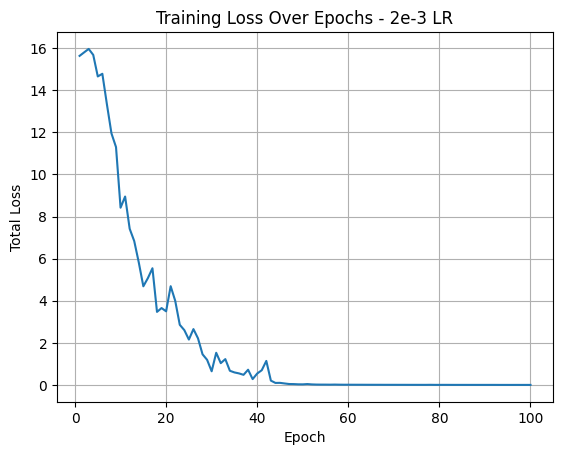

In [128]:
plt.plot(range(1, len(losses) + 1), losses)
plt.xlabel("Epoch")
plt.ylabel("Total Loss")
plt.title("Training Loss Over Epochs - 2e-3 LR")
plt.grid(True)
plt.show()

# **9. Testing Loop**

In [129]:
idx2label = {0: "negative", 1: "neutral", 2: "positive"}

In [130]:
def predict(text, transformer_blocks, classifier_head):
  forward(text, transformer_blocks, classifier_head)
  probs = classifier_head.cached['probs']
  pred_idx = np.argmax(probs)
  return idx2label[pred_idx]

In [131]:
def test_model(test_data, transformer_blocks, classifier_head):
    correct = 0
    total = 0
    accuracies = []
    true_labels = []
    predicted_labels = []

    for i, (text, label) in enumerate(test_data):
        pred_label = predict(text, transformer_blocks, classifier_head)
        true_labels.append(label2idx[label])
        predicted_labels.append(label2idx[pred_label])

        if pred_label == label:
            correct += 1
        total += 1

        accuracy = correct / total
        accuracies.append(accuracy)

    return accuracies, true_labels, predicted_labels

In [132]:
test_data = (list(zip(test['message'], test['sentiment'])))

In [133]:
accuracies, true_labels, predicted_labels = test_model(test_data, transformer_blocks, classifier_head)

Logits: [ 1.95 -2.71 -0.3 ]
Probs: [0.9  0.01 0.09]
Logits: [-0.48 -2.71  2.45]
Probs: [0.05 0.01 0.94]
Logits: [ 6.36 -7.61  1.21]
Probs: [0.99 0.   0.01]
Logits: [-2.53 -2.89  5.7 ]
Probs: [0. 0. 1.]
Logits: [ 0.78 -6.06  4.4 ]
Probs: [0.03 0.   0.97]
Logits: [-1.5  -5.15  6.79]
Probs: [0. 0. 1.]
Logits: [ 5.53 -4.52 -2.65]
Probs: [1. 0. 0.]
Logits: [ 0.1  -5.63  4.98]
Probs: [0.01 0.   0.99]
Logits: [ 2.9  -2.48 -0.34]
Probs: [0.96 0.   0.04]
Logits: [-2.15 -3.23  6.55]
Probs: [0. 0. 1.]
Logits: [-1.96 -5.75  7.35]
Probs: [0. 0. 1.]
Logits: [-0.08 -3.68  3.13]
Probs: [0.04 0.   0.96]
Logits: [ 7.42 -6.09 -2.74]
Probs: [1. 0. 0.]
Logits: [ 7.64 -2.56 -5.99]
Probs: [1. 0. 0.]
Logits: [-0.81 -6.3   7.39]
Probs: [0. 0. 1.]
Logits: [ 5.04 -4.67 -2.06]
Probs: [1. 0. 0.]
Logits: [ 2.62 -5.36  3.02]
Probs: [0.4 0.  0.6]
Logits: [ 4.58 -9.29  3.33]
Probs: [0.78 0.   0.22]
Logits: [ 7.06 -4.83 -3.74]
Probs: [1. 0. 0.]
Logits: [-2.02 -3.9   5.  ]
Probs: [0. 0. 1.]
Logits: [-0.49 -6.67  5.9 ]
P

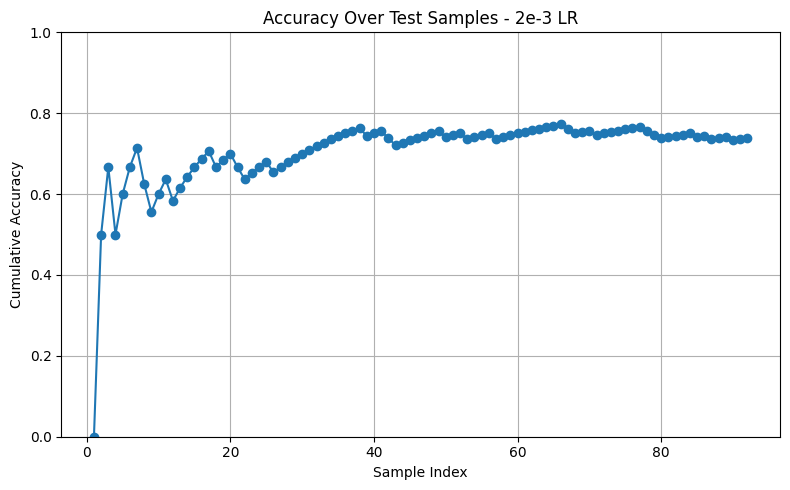

In [134]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o')
plt.xlabel("Sample Index")
plt.ylabel("Cumulative Accuracy")
plt.title("Accuracy Over Test Samples - 2e-3 LR")
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

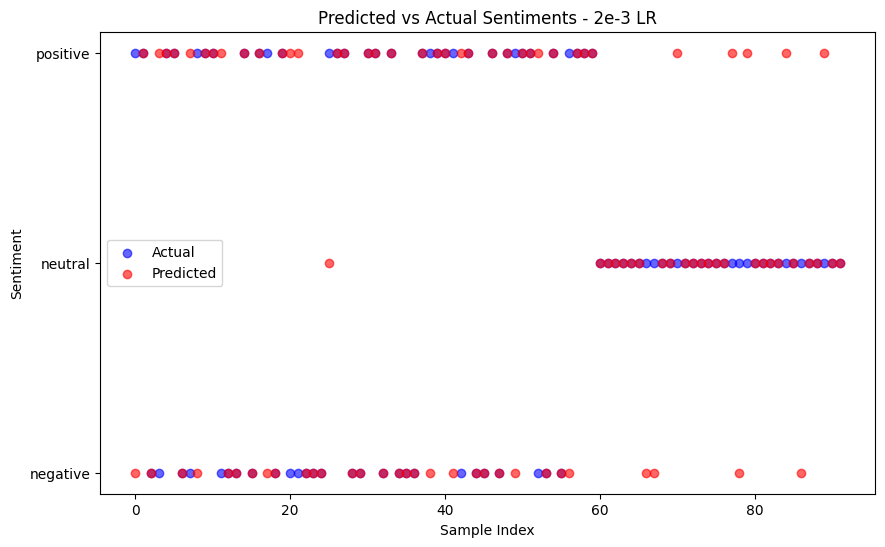

In [135]:
plt.figure(figsize=(10, 6))
plt.scatter(range(len(test_data)), true_labels, color='blue', label='Actual', alpha=0.6)
plt.scatter(range(len(test_data)), predicted_labels, color='red', label='Predicted', alpha=0.6)
plt.yticks([0, 1, 2], list(label2idx.keys()))
plt.xlabel("Sample Index")
plt.ylabel("Sentiment")
plt.title("Predicted vs Actual Sentiments - 2e-3 LR")
plt.legend()
plt.show()

In [136]:
np.mean(accuracies)

np.float64(0.7063341925743762)

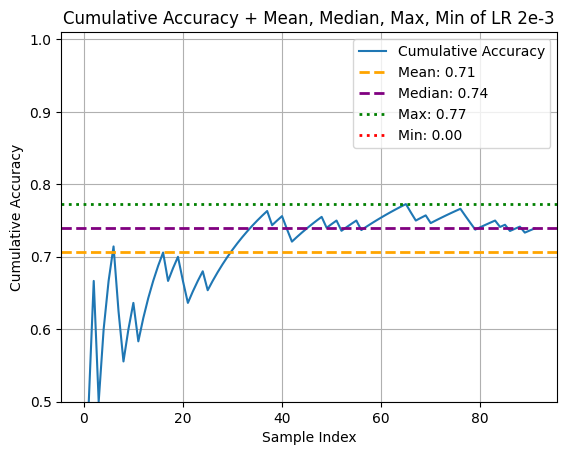

In [137]:
sample_indices = np.arange(len(accuracies))
plt.plot(sample_indices, accuracies, label="Cumulative Accuracy")

mean_acc = np.mean(accuracies)
median_acc = np.median(accuracies)
max_acc = np.max(accuracies)
min_acc = np.min(accuracies)

plt.axhline(mean_acc, color='orange', linestyle='--', linewidth=2, label=f"Mean: {mean_acc:.2f}")
plt.axhline(median_acc, color='purple', linestyle='--', linewidth=2, label=f"Median: {median_acc:.2f}")
plt.axhline(max_acc, color='green', linestyle=':', linewidth=2, label=f"Max: {max_acc:.2f}")
plt.axhline(min_acc, color='red', linestyle=':', linewidth=2, label=f"Min: {min_acc:.2f}")

plt.xlabel("Sample Index")
plt.ylabel("Cumulative Accuracy")
plt.title("Cumulative Accuracy + Mean, Median, Max, Min of LR 2e-3")
plt.ylim(0.5, 1.01)
plt.legend()
plt.grid(True)
plt.show()

# **10. Save Model Checkpoint**

This will be for saving model prototypes I think are good so far.

In [138]:
import pickle

with open("model_checkpoint_5.pkl", "wb") as f:
    pickle.dump({
        "embedding_matrix": embedding_matrix,
        "transformer_blocks": transformer_blocks,
        "classifier_head": classifier_head,
        "label2idx": label2idx,
        "idx2label": idx2label,
        "word2idx": word2idx
    }, f)

# **11. Final Model Structure**

This will be where I create a final class where I save final models.

In [139]:
class SimpleSentimentAnalyzer:
  def __init__(self, word2idx, embedding_matrix, transformer_blocks, classifier_head, label2idx, idx2label):
    self.dim = 128
    self.lemmatizer = WordNetLemmatizer()
    self.word2idx = word2idx
    self.embedding_matrix = embedding_matrix
    self.transformer_blocks = transformer_blocks
    self.classifier_head = classifier_head
    self.label2idx = label2idx
    self.idx2label = idx2label

  def tokenize(self, text):
    text = re.sub(r"http\\S+|www\\S+", "", text)
    text = re.sub(r"@[\\w_]+", "", text)
    text = re.sub(r"#(\\w+)", r"\\1", text)
    text = re.sub(r"[^a-z0-9\\s]", " ", text)
    text = re.sub(r"\s+", " ", text)

    tokens = text.split()
    tokens = [self.lemmatizer.lemmatize(token) for token in tokens]
    return tokens

  def generate_embeddings(self, text):
    tokens = self.tokenize(text)
    indices = [self.word2idx.get(token, self.word2idx["<UNK>"]) for token in tokens]
    embeddings = []

    for index in indices:
      embeddings.append(self.embedding_matrix[index])

    return np.array(embeddings)

  def positional_encode(self, embeddings): #input an embedded sentence
    for pos, embedding in enumerate(embeddings):
      for i, _ in enumerate(embedding):
        exp = (2 * i) / self.dim
        den = 10000 ** exp
        val = pos / den
        if i % 2 == 0:
          embedding[i] += np.sin(val)
        else:
          embedding[i] += np.cos(val)
      embeddings[pos] = embedding

    return embeddings

  def softmax(self, x):
    x = x - np.max(x, axis=-1, keepdims=True)
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

  def multi_head_attention(self, X, W_q_heads, W_k_heads, W_v_heads, W_o):
    outputs = []
    A_list = []
    Q_list = []
    K_list = []
    V_list = []

    for idx, (W_q, W_k, W_v), in enumerate(zip(W_q_heads, W_k_heads, W_v_heads)):
      Q = X @ W_q
      K = X @ W_k
      V = X @ W_v

      scores = Q @ K.T
      head_dim = Q.shape[-1]
      scores_scaled = scores / np.sqrt(head_dim)
      A = self.softmax(scores_scaled)

      output = A @ V

      outputs.append(output)
      A_list.append(A)
      Q_list.append(Q)
      K_list.append(K)
      V_list.append(V)

    concat = np.concatenate(outputs, axis=-1)

    out = concat @ W_o

    return out, A_list, Q_list, K_list, V_list

  def add_substep(self, X, substep):
    return X + substep

  def LayerNorm(self, X, gamma, beta, eps=1e-5):
    mean = X.mean(axis=1, keepdims=True)
    var = X.var(axis=1, keepdims=True)
    norm = (X - mean) / np.sqrt(var + eps)
    output = gamma * norm + beta

    return output

  def relu(self, x):
    return np.maximum(0, x)

  def ffn(self, X, W_1, W_2, b_1, b_2):
    h1 = X @ W_1 + b_1
    a1 = self.relu(h1)

    output = a1 @ W_2 + b_2

    return output, a1, h1

  def forward(self, text):
    X = self.generate_embeddings(text)
    X = self.positional_encode(X)

    for block in self.transformer_blocks:
      X = block.forward(X, self)

    x_cls = X[0]
    probs, logits = self.classifier_head.probabilities(x_cls)

    self.classifier_head.cached['logits'] = logits
    self.classifier_head.cached['x_cls'] = x_cls
    self.classifier_head.cached['probs'] = probs

    return probs, logits

  def predict(self, text):
    self.forward(text)
    probs = self.classifier_head.cached['probs']
    pred_idx = np.argmax(probs)
    return self.idx2label[pred_idx]

In [140]:
analyzer = SimpleSentimentAnalyzer(word2idx, embedding_matrix, transformer_blocks, classifier_head, label2idx, idx2label)
with open("sentiment_analyzer_4.pkl", "wb") as f:
    pickle.dump({
        "analyzer": analyzer
    }, f)

In [141]:
!pip freeze > requirements.txt

# **13. Notes & Logs**

**Learning Rates + File:**

1e-3 -> sentiment_analyzer_1.pkl

1e-2 -> sentiment_analyzer_2.pkl

1e-4 -> sentiment_analyzer_3.pkl

2e-3 -> sentiment_analyzer_4.pkl

**Refer to `sentiment_analyzer_demo.ipynb` for a test with an inputted sentence.**